# Business case

The dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

# Business task

Based on the features available in the dataset.Build an effective machine learning model to predict wheather an individual has diabetes or not.

# Import necessary packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix,plot_roc_curve,classification_report,accuracy_score,precision_score,recall_score,f1_score

# Loading dataset

In [2]:
df = pd.read_csv('Downloads\\diabetes.csv')

# Overview and statistical summary

In [3]:
df.shape

(768, 9)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


# Data cleaning

In [6]:
#checking for null values
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

There are no null values in the dataset

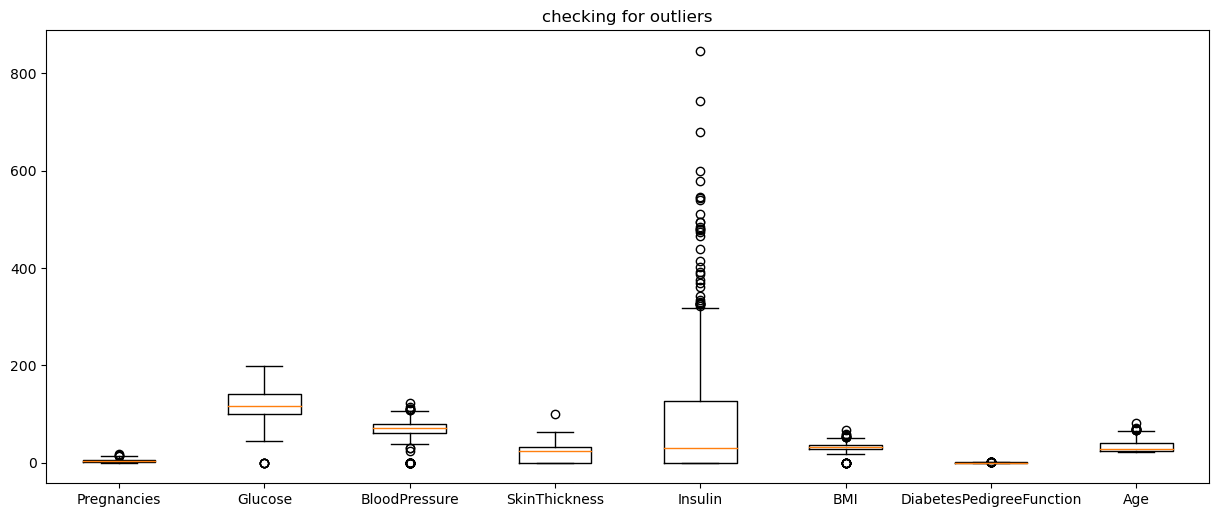

In [7]:
#checking for outliers
plt.figure(figsize=(15,6),dpi=100)
plt.boxplot(df[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BMI', 'DiabetesPedigreeFunction', 'Age']],labels=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BMI', 'DiabetesPedigreeFunction', 'Age'])
plt.title('checking for outliers');

Almost every column has outliers.As there are only 768 observations.Instead of removing the outliers, I will be replacing them with higher and lower limit values

In [8]:
# creating a helper function to optimise the values
def optimise_values(n):
    if n>=upper_limit:
        return upper_limit
    elif n<=lower_limit:
        return lower_limit
    else:
        return n

In [9]:
# looping through the columns and changing the values
cols = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BMI', 'DiabetesPedigreeFunction', 'Age']

for i in cols:
    perc_25 = df[i].quantile(.25)
    perc_75 = df[i].quantile(.75)
    iqr = perc_75 - perc_25
    upper_limit = perc_75 + 1.5 * iqr
    lower_limit = perc_25 - 1.5 * iqr
    df[i]=df[i].apply(optimise_values)

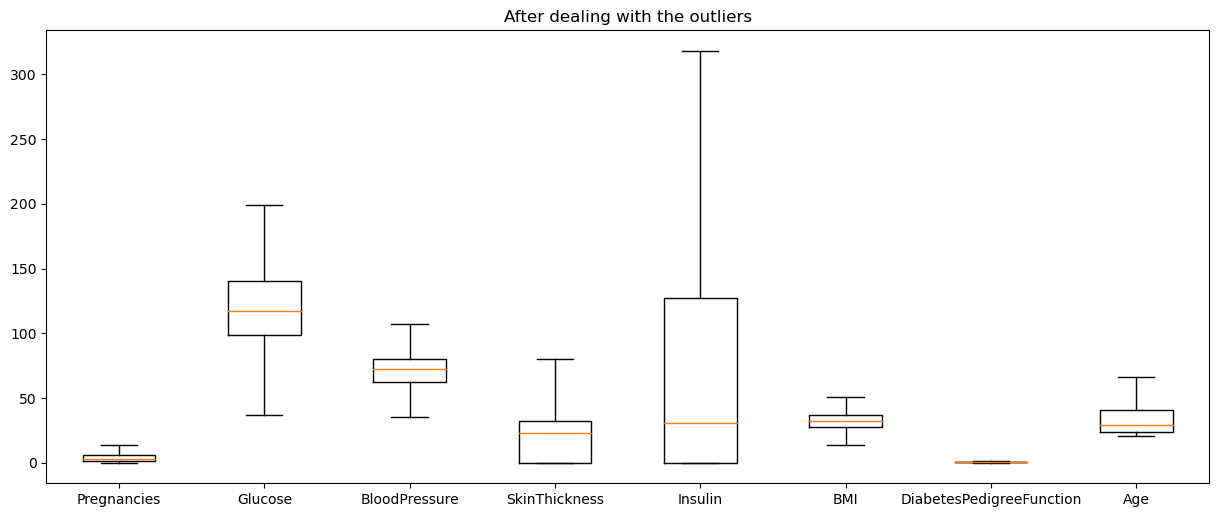

In [10]:
plt.figure(figsize=(15,6),dpi=100)
plt.boxplot(df[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BMI', 'DiabetesPedigreeFunction', 'Age']],labels=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BMI', 'DiabetesPedigreeFunction', 'Age'])
plt.title('After dealing with the outliers');

# Exploratory data analysis

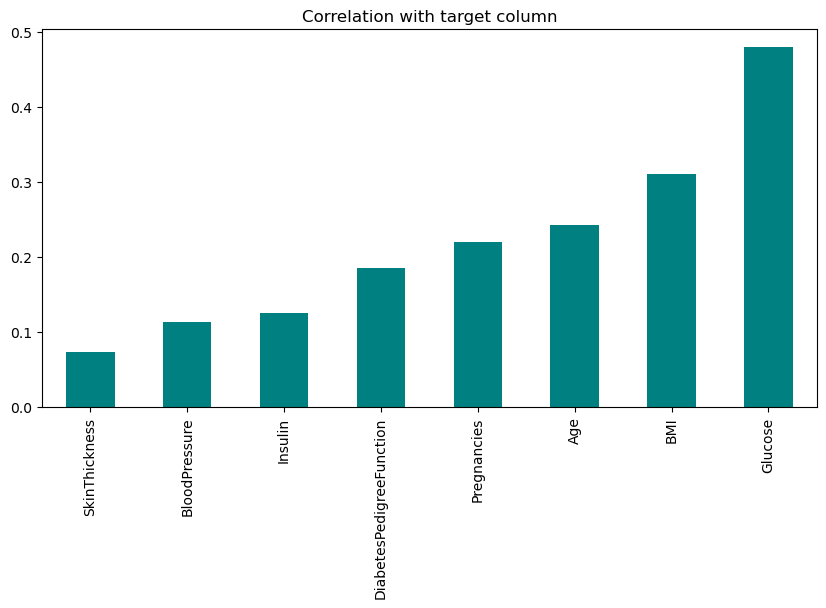

In [11]:
# lets look at the correlation of other features with target column
plt.figure(figsize=(10,5),dpi=100)
df.corr()['Outcome'].sort_values(ascending=True)[:-1].plot(kind='bar',color='teal')
plt.title('Correlation with target column');

All the features are positively correlated with target column, with Glucose and BMI being two top highly correlated variables.

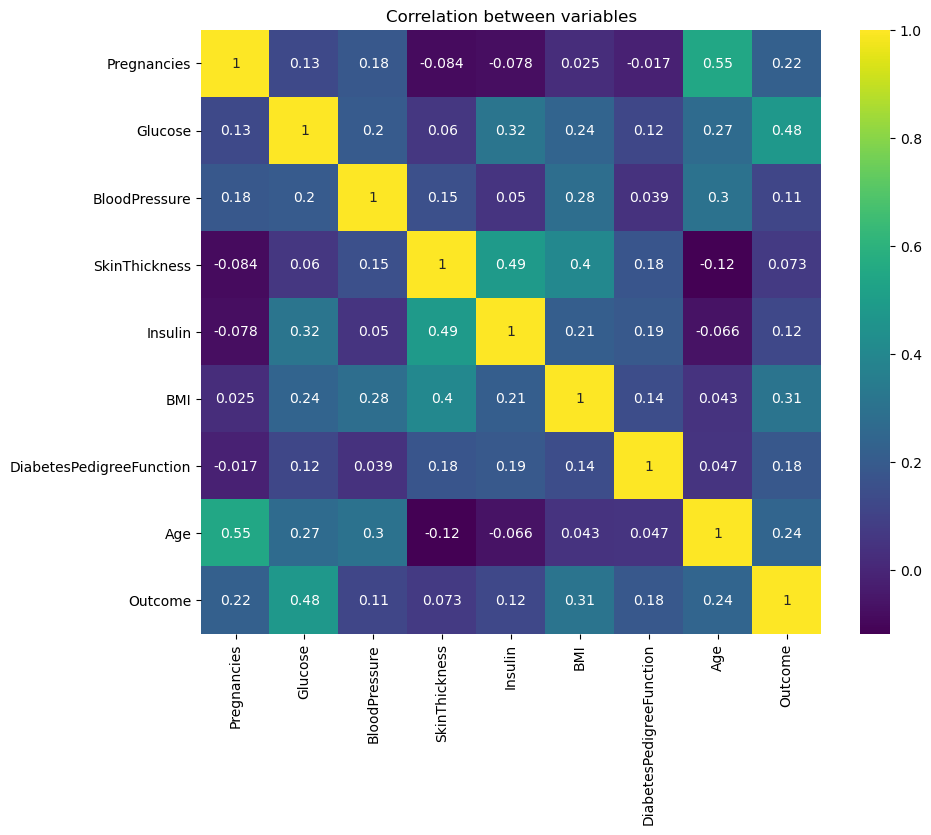

In [12]:
#lets understand the correlation between variables
plt.figure(figsize=(10,8),dpi=100)
sns.heatmap(df.corr(),annot=True,cmap='viridis')
plt.title('Correlation between variables');

Age and Pregnancies are highly correlated, also SkinThickness and Insulin.

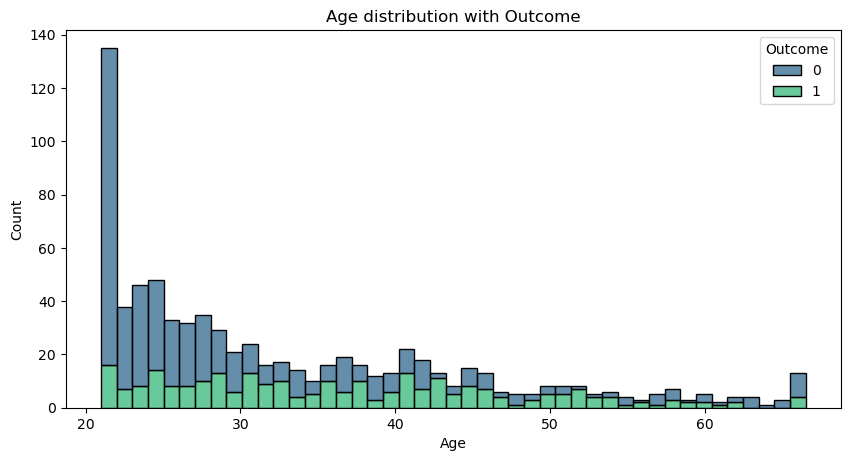

In [13]:
# age distribution with outcome
plt.figure(figsize=(10,5),dpi=100)
sns.histplot(data=df,x='Age',hue='Outcome',palette='viridis',multiple='stack',bins=45)
plt.title('Age distribution with Outcome');

Age distribution is skewed and majority are aged 21

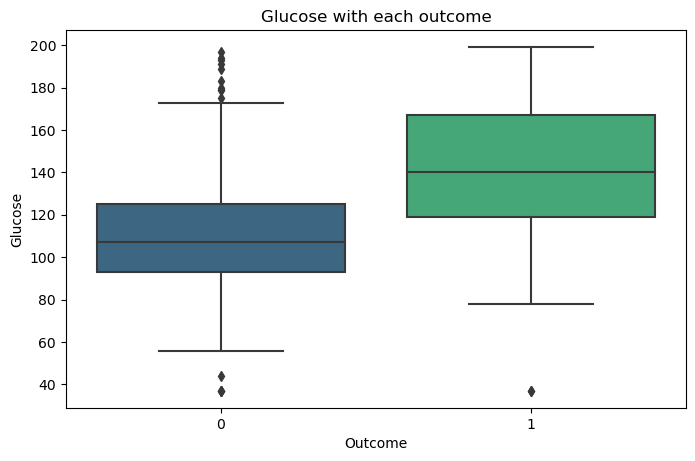

In [14]:
# checking outcome based on glucose
plt.figure(figsize=(8,5),dpi=100)
sns.boxplot(data=df,x='Outcome',y='Glucose',palette='viridis')
plt.title('Glucose with each outcome');

Individuals with diabetes have median glucose level around 140, whereas individuals without have around 110. 

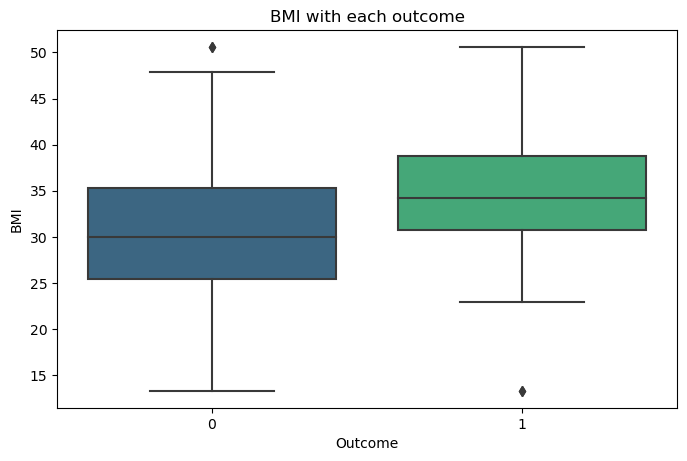

In [15]:
# checking outcome based on BMI
plt.figure(figsize=(8,5),dpi=100)
sns.boxplot(data=df,x='Outcome',y='BMI',palette='viridis')
plt.title('BMI with each outcome');

People with diabetes have higher median BMI than people without diabetes.

<AxesSubplot:xlabel='Outcome', ylabel='count'>

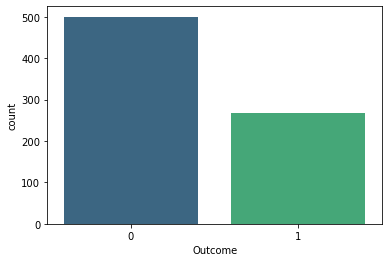

In [16]:
#checking for class imbalance
sns.countplot(data=df,x='Outcome',palette='viridis')

There is a little class imbalance, but it is ok.

In [17]:
df['Outcome'].value_counts(normalize=True)*100

0    65.104167
1    34.895833
Name: Outcome, dtype: float64

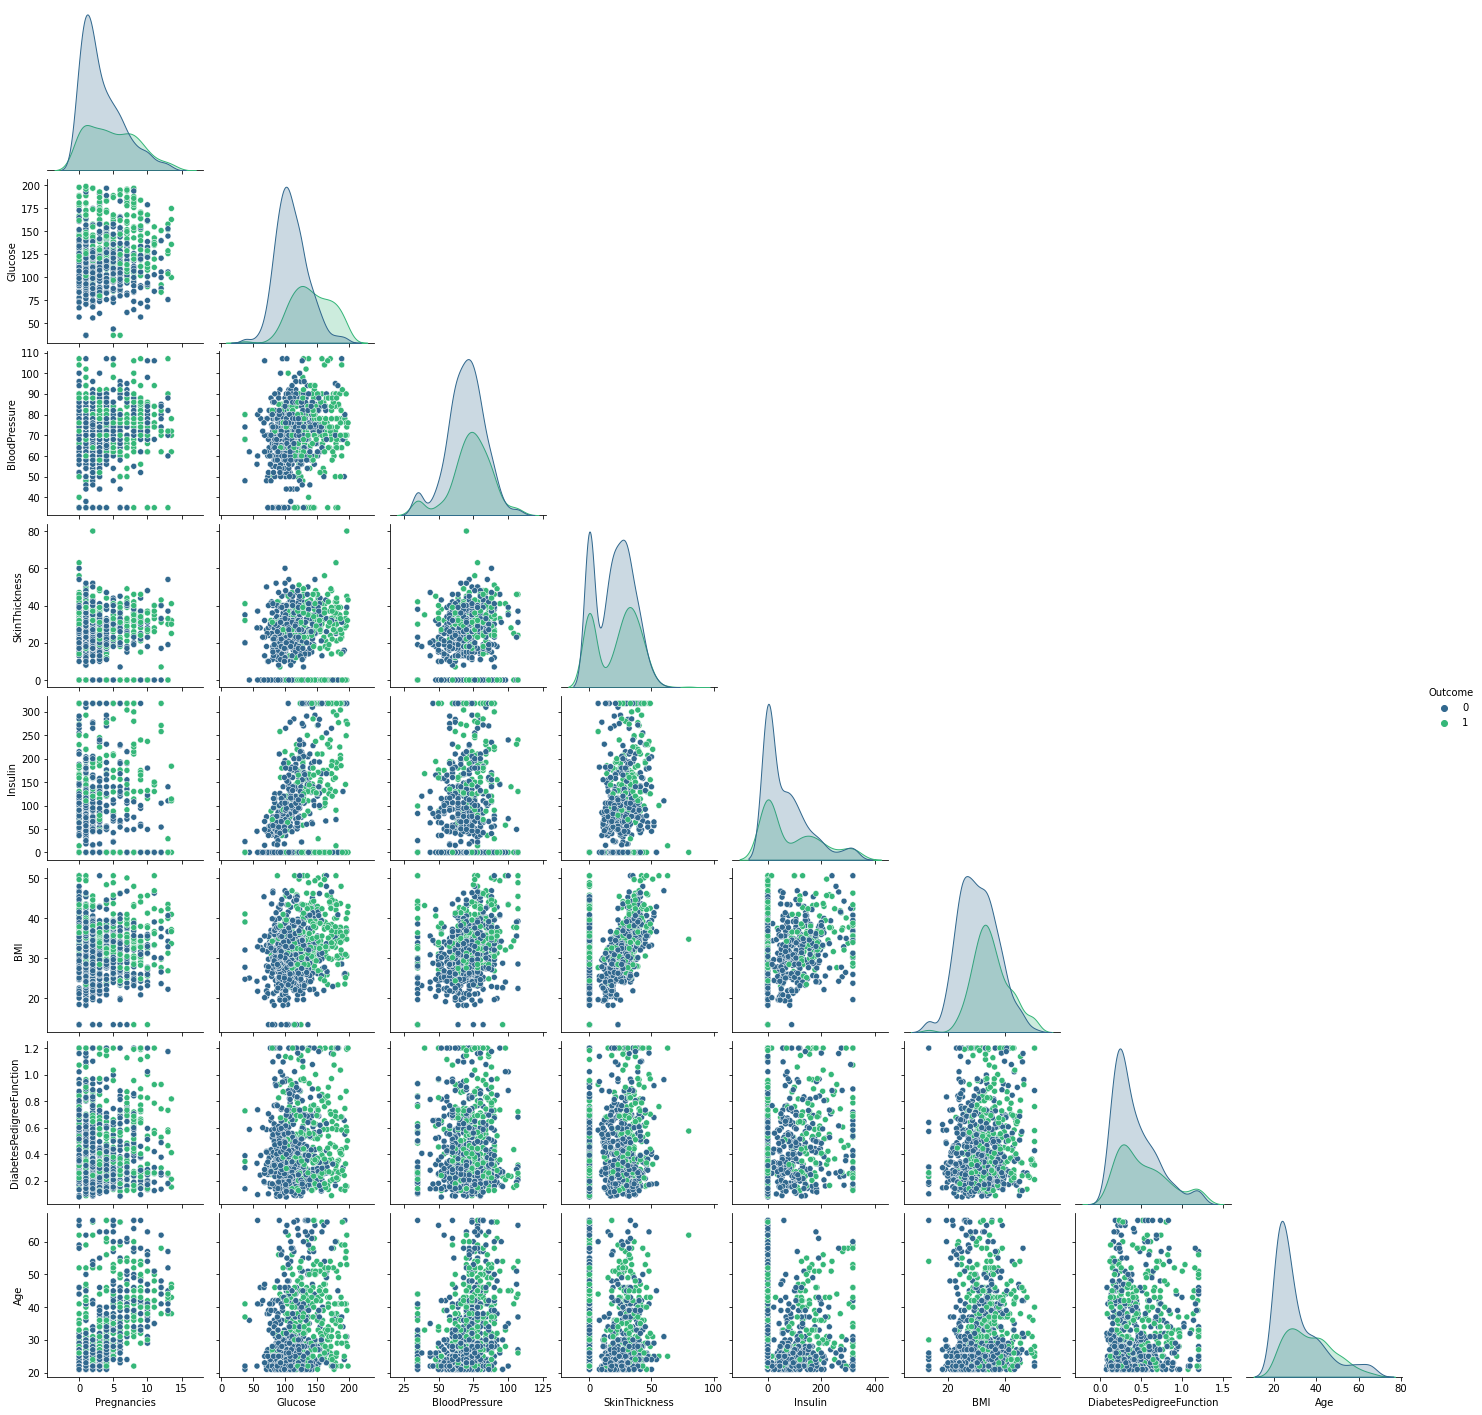

In [40]:
#plotting paiplot to understand the relationship between variables
sns.pairplot(df,hue='Outcome',corner=True,palette='viridis');

# Creating X,y and doing train - test split

In [18]:
X = df.drop('Outcome',axis=1)
y = df['Outcome']

In [19]:
scale = StandardScaler()

In [20]:
# setting test size to .20 and setting stratify = y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,stratify=y, random_state=42)

In [21]:
# scaling the test and train data
X_train_scaled = scale.fit_transform(X_train)
X_test_scaled = scale.transform(X_test)

# Model building

# Logistic Regression

In [22]:
log_model = LogisticRegression(class_weight='balanced')

In [23]:
log_model.fit(X_train_scaled,y_train)

LogisticRegression(class_weight='balanced')

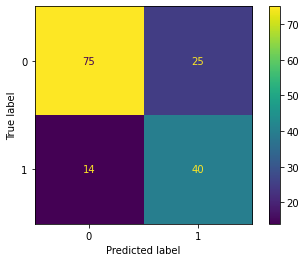

In [24]:
plot_confusion_matrix(log_model,X_test_scaled,y_test)

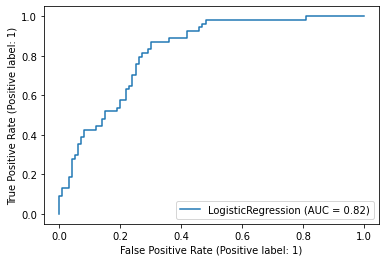

In [25]:
plot_roc_curve(log_model,X_test_scaled,y_test)

In [26]:
y_pred = log_model.predict(X_test_scaled)

In [27]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.84      0.75      0.79       100
           1       0.62      0.74      0.67        54

    accuracy                           0.75       154
   macro avg       0.73      0.75      0.73       154
weighted avg       0.76      0.75      0.75       154



In [28]:
Scores = {'Accuracy':round(accuracy_score(y_test,y_pred),3),'F1_score':round(f1_score(y_test,y_pred),3),'Recall':round(recall_score(y_test,y_pred),3),'Precision':round(precision_score(y_test,y_pred),3)}
Scores

{'Accuracy': 0.747, 'F1_score': 0.672, 'Recall': 0.741, 'Precision': 0.615}

In [29]:
df_lr=pd.DataFrame(data=Scores,index=['Logistic_regression'])
df_lr

,Accuracy,F1_score,Recall,Precision
Logistic_regression,0.747,0.672,0.741,0.615


# KNN

In [30]:
#choosing right number of neighbours based on error rate
test_error_rates = []
for k in range(1,20):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train_scaled,y_train)
    y_pred = knn_model.predict(X_test_scaled)
    error = 1 - accuracy_score(y_test,y_pred)
    test_error_rates.append(error)

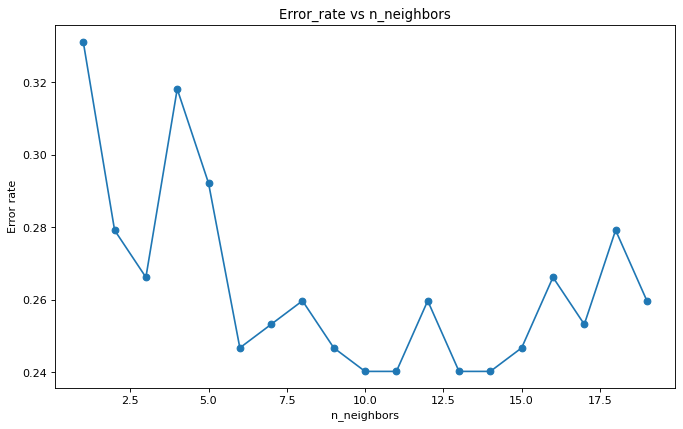

In [31]:
#plotting elbow line chart
plt.figure(figsize=(10,6),dpi=80)
plt.plot(range(1,20),test_error_rates,marker='o')
plt.ylabel('Error rate')
plt.xlabel('n_neighbors')
plt.title('Error_rate vs n_neighbors');

In [32]:
# choosing k = 10 and rebuilding the model
knn_model_new = KNeighborsClassifier(n_neighbors=10)

In [33]:
knn_model_new.fit(X_train_scaled,y_train)

KNeighborsClassifier(n_neighbors=10)

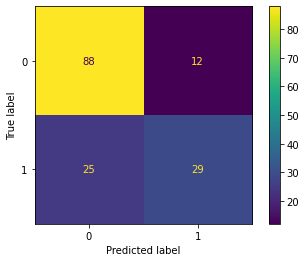

In [34]:
plot_confusion_matrix(knn_model_new,X_test_scaled,y_test)

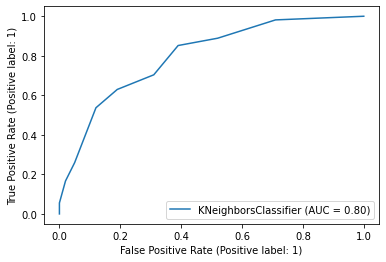

In [35]:
plot_roc_curve(knn_model_new,X_test_scaled,y_test)

In [36]:
y_pred = knn_model_new.predict(X_test_scaled)

In [37]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.78      0.88      0.83       100
           1       0.71      0.54      0.61        54

    accuracy                           0.76       154
   macro avg       0.74      0.71      0.72       154
weighted avg       0.75      0.76      0.75       154



In [38]:
Scores = {'Accuracy':round(accuracy_score(y_test,y_pred),3),'F1_score':round(f1_score(y_test,y_pred),3),'Recall':round(recall_score(y_test,y_pred),3),'Precision':round(precision_score(y_test,y_pred),3)}
Scores

{'Accuracy': 0.76, 'F1_score': 0.611, 'Recall': 0.537, 'Precision': 0.707}

In [39]:
df_knn=pd.DataFrame(data=Scores,index=['KNN(n_neighbor=10)'])
df_knn

,Accuracy,F1_score,Recall,Precision
KNN(n_neighbor=10),0.76,0.611,0.537,0.707


# KNN with grid search

In [45]:
params = {'n_neighbors':[5,6,7,8,9,10,11,12]}

In [42]:
knn_model_grid = KNeighborsClassifier()

In [46]:
grid_model = GridSearchCV(estimator=knn_model_grid,param_grid=params)

In [47]:
%%time
grid_model.fit(X_train_scaled,y_train)

Wall time: 219 ms


GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [5, 6, 7, 8, 9, 10, 11, 12]})

In [48]:
grid_model.best_params_

{'n_neighbors': 8}

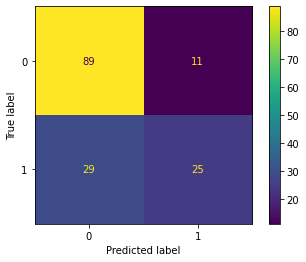

In [49]:
plot_confusion_matrix(grid_model,X_test_scaled,y_test)

In [50]:
grid_model.best_score_

0.7590030654404905

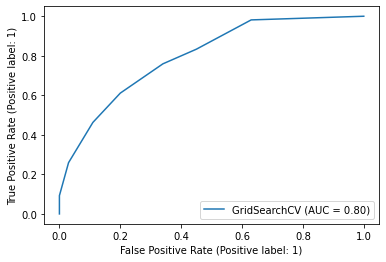

In [58]:
plot_roc_curve(grid_model,X_test_scaled,y_test)

In [51]:
y_pred = grid_model.predict(X_test_scaled)

In [52]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.75      0.89      0.82       100
           1       0.69      0.46      0.56        54

    accuracy                           0.74       154
   macro avg       0.72      0.68      0.69       154
weighted avg       0.73      0.74      0.73       154



In [53]:
Scores = {'Accuracy':round(accuracy_score(y_test,y_pred),3),'F1_score':round(f1_score(y_test,y_pred),3),'Recall':round(recall_score(y_test,y_pred),3),'Precision':round(precision_score(y_test,y_pred),3)}
Scores

{'Accuracy': 0.74, 'F1_score': 0.556, 'Recall': 0.463, 'Precision': 0.694}

In [54]:
df_knn_grid = pd.DataFrame(data=Scores,index=['KNN_grid_search'])
df_knn_grid

,Accuracy,F1_score,Recall,Precision
KNN_grid_search,0.74,0.556,0.463,0.694


Based on lowest error rate by plotting elbow line graph, I manually chose n_neighbors = 10, whereas the grid search cv chose n_neighbors = 8

# Summary

In [55]:
df1 = pd.concat([df_lr,df_knn])
df1

,Accuracy,F1_score,Recall,Precision
Logistic_regression,0.747,0.672,0.741,0.615
KNN(n_neighbor=10),0.760,0.611,0.537,0.707


In [57]:
df_final = pd.concat([df1,df_knn_grid])
df_final

,Accuracy,F1_score,Recall,Precision
Logistic_regression,0.747,0.672,0.741,0.615
KNN(n_neighbor=10),0.760,0.611,0.537,0.707
KNN_grid_search,0.740,0.556,0.463,0.694


* **Based on F1_score and Recall the logistic regression has performed better. On the other hand, based on precision the KNN model with n_neighbor = 10 has performed well.**
* **But more qualitative data is needed further to increase the models accuracy.**

**Thank you!**